<a href="https://colab.research.google.com/github/TatKhachatryan/Classification-Project/blob/main/Mobile_Price_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install -c conda-forge python-kaleido

In [33]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

### **Neccessary Funcitons**

In [48]:
def metric_results(y, y_pred):
    result =  pd.DataFrame({'Metric':['accuracy','sensitivity','specificity','precision','f1-score'],
            'Value':[metrics.accuracy_score(y, y_pred),
                     metrics.recall_score(y, y_pred,pos_label=0, average='macro'),
                     metrics.recall_score(y, y_pred, average='macro'),
                     metrics.precision_score(y, y_pred, average='macro'),
                     metrics.f1_score(y, y_pred, average='macro')]})
    result["Value"] = (result["Value"] * 100).round(2).astype(str) + '%'                            
    return result

### Data Processing

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/train.csv', header=0)
test = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/test.csv', header=0)

print("Train Size: ", train.shape)
print("Test Size: ", test.shape)

Train Size:  (2000, 21)
Test Size:  (1000, 21)


Dataset columns are as follows:

* **id** - ID
* **battery_power** - Total energy a battery can store in one time measured in mAh (milliampere hour - is 1000th of an ampere hour ( Ah ))
* **blue** - Has bluetooth or not
* **clock_speed** - Speed at which microprocessor executes instructions
* **dual_sim** - Has dual sim support or not
* **fc** - Front Camera mega pixels
* **four_g** - Has 4G or not
* **int_memory** - Internal Memory in Gigabytes
* **m_dep** - Mobile Depth in cm
* **mobile_wt** - Weight of mobile phone
* **n_cores** - Number of cores of processor
* **pc** - Primary Camera mega pixels
* **px_height** - Pixel Resolution Height
* **px_width** - Pixel Resolution Width
* **ram** - Random Access Memory in Megabytes
* **sc_h** - Screen Height of mobile in cm
* **sc_w** - Screen Width of mobile in cm
* **talk_time** - Longest time that a single battery charge will last when you are
* **three_g** - Has 3G or not
* **touch_screen** - Has touch screen or not
* **wifi** - Has wifi or not
* **price_range** - This is the target variable with value of:
** 0 (low cost)
** 1 (medium cost)
** 2 (high cost)
** 3 (very high cost)

# EDA

In [3]:
train.describe()
train['price_range'].unique()

array([1, 2, 3, 0])

So we have a multi-class classification problem.

Machine learning algorithm for multiclass classification:
* Decision Trees,
* k-Nearest Neighbors,
* Naive Bayes
* Support Vector Machine 

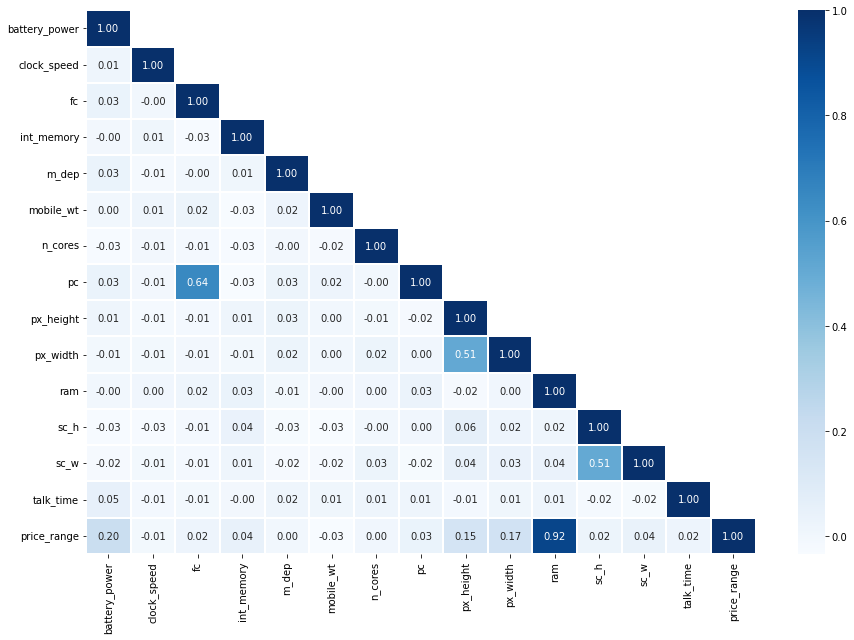

In [18]:
plt.figure(figsize = (15,10))

corr = train[['battery_power', 'clock_speed', 'fc',  'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
               'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'price_range']].corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f', linewidths=0.2, cmap="Blues")
plt.show()

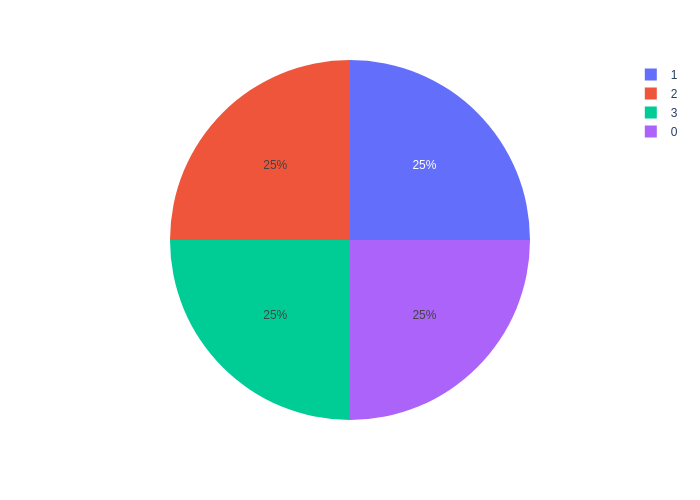

In [7]:
fig = px.pie(train, names = train['price_range'].value_counts().index, values = train['price_range'].value_counts().values)
fig.show(renderer="png")

So all the classes are equaly distributed.

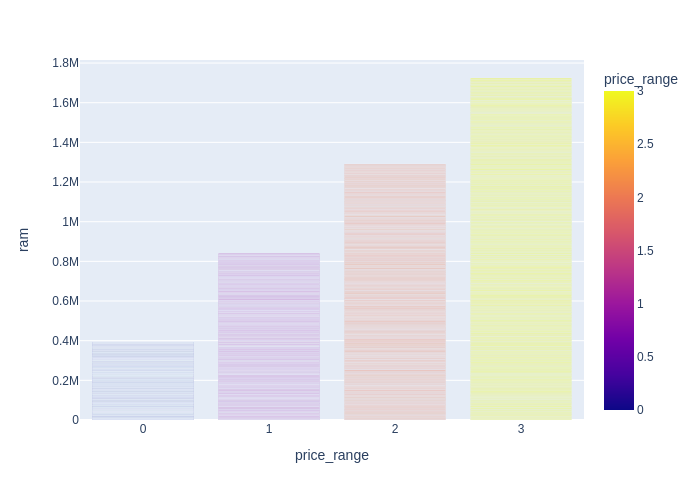

In [20]:
fig = px.bar(train, x='price_range', y='ram',  color='price_range')
fig.show(renderer="png")

This graph shows that when the ram gets higher, the price range gets higher too.

# Feature Importance
I'm going to choose most important features using RandomForestClassifier.

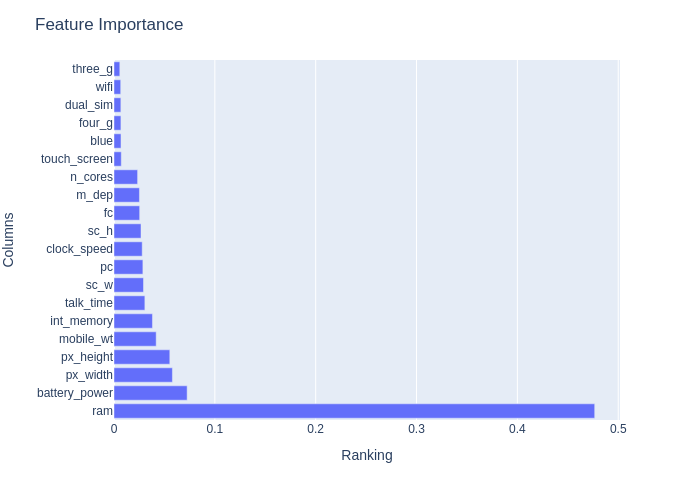

In [24]:
X = train.drop(['price_range'], axis=1)

y = train['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
ranking = np.argsort(-rf.feature_importances_)

fig = px.bar(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orientation='h')
fig.update_layout(title='Feature Importance',
                  xaxis_title="Ranking",
                  yaxis_title="Columns",)
fig.show(renderer="png")

We can see that from all the features "ram", "battery_power", "px_height" and "px_width" have the highest feature importance. To make our decision tree model not too complex and improve it's accuracy, I'll build my model based on these 4 features.

# Models. Decision Tree

In [25]:
# Filter dataset
selected_features = ["ram", "battery_power", "px_height", "px_width"]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0, min_samples_leaf=5)
clf_en.fit(X_train, y_train)
y_pred_en = clf_en.predict(X_test)

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))
y_pred_train_en = clf_en.predict(X_train)
y_pred_train_en

Model accuracy score with criterion entropy: 0.7550


array([1, 3, 1, ..., 1, 2, 1])

In [27]:
cm = confusion_matrix(y_test, y_pred_en)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[79 26  0  0]
 [ 4 73 14  0]
 [ 0 16 59 17]
 [ 0  0 21 91]]


In [31]:
# Generate classification report for training set

y_pred_train = clf_en.predict(X_train)
print("\n\t  Classification report for training set")
print("-"*55)
print(classification_report(y_train, y_pred_train))

# Generate classification report for test set
y_pred_test = clf_en.predict(X_test)
print("\n\t   Classification report for test set")
print("-"*55)
print(classification_report(y_test, y_pred_test))
print('\n')


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       395
           1       0.65      0.83      0.73       409
           2       0.72      0.61      0.66       408
           3       0.83      0.88      0.85       388

    accuracy                           0.77      1600
   macro avg       0.78      0.77      0.77      1600
weighted avg       0.78      0.77      0.77      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       105
           1       0.63      0.80      0.71        91
           2       0.63      0.64      0.63        92
           3       0.84      0.81      0.83       112

    accuracy                           0.76       400
   macro avg       0.76      0.75      0.75 

So here is the summary:



*   **precision** answers the following question: "How many of those that we predicted in a certain price range is actually in that range?"

*   **recall** shows how much was correctly identified as let's say 0 (low cost) to how much was actually 0. In this case, it answers the following question: "Of all the price ranges that we predicted (0, 1, 2, 3) how many did we correctly predict?"

*   **f1-score** is considered a better indicator of the classifier’s performance than the regular accuracy measure. It is the harmonic mean(average) of the precision and recall. The higher the F1 score the better, with 0 being the worst possible and 1 being the best.

*   **support** is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.











In [47]:
metric_results(y_test, y_pred_test)

,Metric,Value
0,accuracy,75.5%
1,sensitivity,75.21%
2,specificity,75.21%
3,precision,76.42%
4,f1-score,75.27%


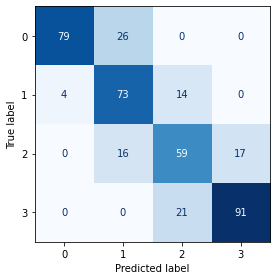

In [37]:
ConfusionMatrixDisplay.from_estimator(clf_en, X_test, y_test, colorbar=False, cmap='Blues')         
plt.tight_layout()
plt.show() 

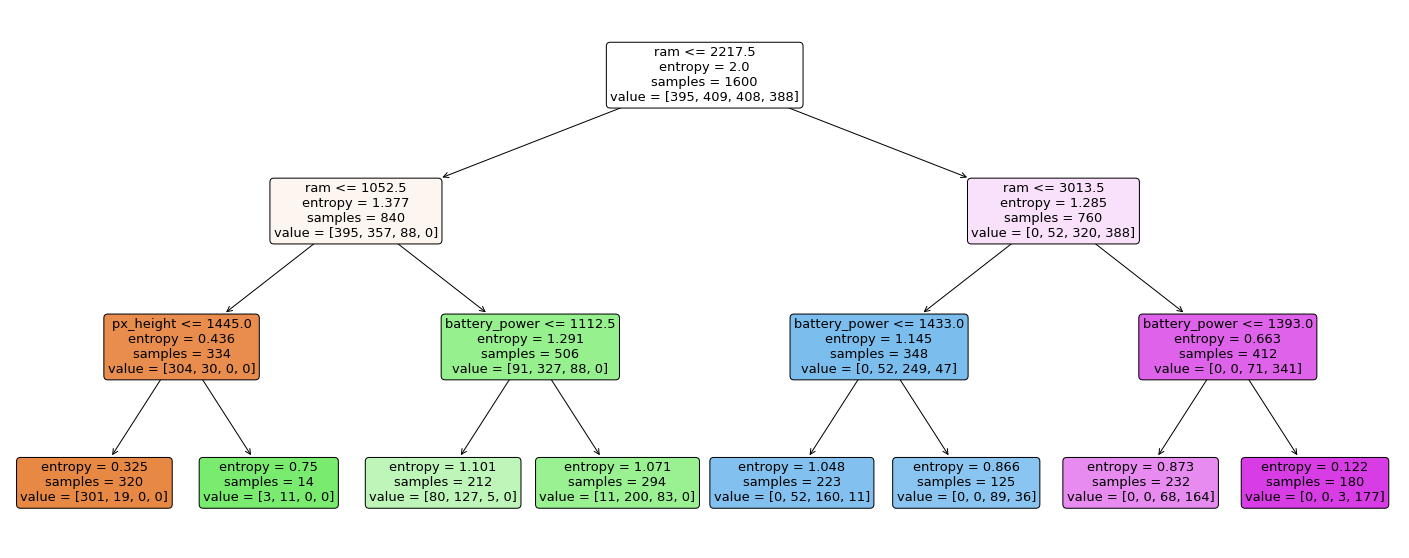

In [32]:
plt.figure(figsize=(25, 10))

fig = plot_tree(clf_en, filled=True, rounded=True, feature_names=X_train.columns, fontsize=13)

plt.show()